# Konkurrenzmodell/Competition model

$$u' = u(1- a_1\cdot u - a_2 \cdot v)$$
$$v' = rv (1-b_1 \cdot u - b_2 \cdot v)$$

Überleben einer Spezies(survival): $$a_1 = 0.3; \quad  a_2 = 0.6; \quad b_1 = 0.7; \quad b_2 = 0.3 \quad r = 0.5$$
Koexistenz(co-existence): $$r = 0.5, \quad a_1=0.7, \quad a_2=0.3, \quad b_1=0.3, \quad b_2=0.6$$

Ref: 
* Author: Hannah Burmester (h.burmester@tu-bs.de)
* Modified: Tirtho Sarathi Saha (t.saha@tu-bs.de)

Kernel: ``sciann``

##### required packages

In [1]:
# sciann doesn't work with the newer virsion of python and tensorflow. Worked with python.version=3.7.16, didn't work with 3.10./3.11. Try with other's later.
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt 
import scipy.io
import csv

# zusätzliche Packages für das Lösen der DGL
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout

style = {'description_width': '100px'}
slider_layout = Layout(width='79%')

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)] 



# SciANN Overview

SciANN is a Python library for scientific machine learning that allows you to build neural network models for solving scientific problems, including ordinary and partial differential equations (ODEs and PDEs). SciANN provides a range of classes and tools to help you define and solve scientific problems with neural networks.

## Key Components and Classes

### `sn.Variable`
- Class to define inputs to the network.

### `sn.Field`
- Class to define outputs of the network.

### `sn.Functional`
- Class to construct a nonlinear neural network approximation.

### `sn.Parameter`
- Class to define a parameter for inversion purposes.

### `sn.Data` and `sn.Tie`
- `sn.Data` is used to define the targets when there are observations for any variable.
- `sn.Tie` is used for physical constraints, such as PDEs or equality relations between different variables.

### `sn.SciModel`
- Class to set up the optimization problem, including inputs to the networks, targets (objectives), and the loss function.

### `sn.math`
- Module for mathematical operations, including functions and operations used in defining scientific problems.
- Supports operator overloading, which improves readability when setting up complex mathematical relations, such as PDEs.


##### utility functions
Q's
1. In ``ode_solver`` we are not giving the argument $q$ for the model ``ode_model``. What about that? Answer: [See documentation!](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)


In [2]:
#Funktionen für das Lösen der DGL 
def ode_model(q, t, r, a1, a2, b1, b2, e0,f0, e1,f1, e2,f2, e3,f3, e4,f4):
    """
    Reference https://www.idmod.org/docs/hiv/model-seir.html
    """
    u, v =q
    
    # DGL ohne zusätzliche Terme # w/o higher order terms
    #dudt = u*(1-a1*u- a2*v) 
    #dvdt = r*v*(1-b1*u-b2*v)
    
    # DGL mit zusätzlichen Termen # higher order terms
    dudt = u*(1-a1*u- a2*v)  +e0 + e1*u + e2*v + e3*u*u*v + e4*u*v*v
    dvdt = r*v*(1-b1*u-b2*v) +f0 + f1*u + f2*v + f3*u*u*v + f4*u*v*v
    
    return [dudt, dvdt]

def ode_solver(t, initial_conditions, params):
    initu, initv = initial_conditions
    #r, a1, a2, b1, b2 = params
    r, a1, a2, b1, b2, e0,f0, e1,f1, e2,f2, e3,f3, e4,f4 = params
    #res = odeint(ode_model, [initu, initv], t, args=(r, a1, a2, b1, b2))
    res = odeint(ode_model, [initu, initv], t, args=(r, a1, a2, b1, b2, e0,f0, e1,f1, e2,f2, e3,f3, e4,f4)) #odeint from scipy.integrate
    return res

#def solveDGL(initu, initv, r, a1, a2, b1, b2, tend):
def solveDGL(initu, initv, r, a1, a2, b1, b2, e0,f0, e1,f1, e2,f2, e3,f3, e4,f4, tend):
    initial_conditions = [initu, initv]
    #params = [r, a1, a2, b1, b2]
    params = [r, a1, a2, b1, b2, e0,f0, e1,f1, e2,f2, e3,f3, e4,f4]
    tspan = np.arange(0, tend, 0.1)
    sol = ode_solver(tspan, initial_conditions, params)
    u,v = sol[:, 0], sol[:, 1]
    
    plt.plot(tspan, u)
    plt.plot(tspan, v)
    plt.show()


In [3]:
MSEU = []
MSEV = []
MSEUV = []
R = []
A1 = []
A2 = []
B1 = []
B2 = []

Create Training Data

Tasks:
1. Create sparse squential input training time data (i.e. tTrain) Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
2. Create accordingly sparse sequential input uTrain, vTrain data.

In [4]:
# Erstellen der Trainingsdaten 

initial_conditions= [2,1] # [initu, initv]
# Überleben einer Spezies
# survival of one species
#params = [0.5, 0.3, 0.6, 0.7, 0.3, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
# Koexistenz
# co-existence
params = [0.5, 0.7, 0.3, 0.3, 0.6, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
tTrain = np.linspace(0,20,50)
sol = ode_solver(tTrain, initial_conditions, params) # Lösen der DGL
uTrain,vTrain = sol[:, 0], sol[:, 1]

In [5]:
print(uTrain.shape, vTrain.shape, tTrain.shape)

(50,) (50,) (50,)


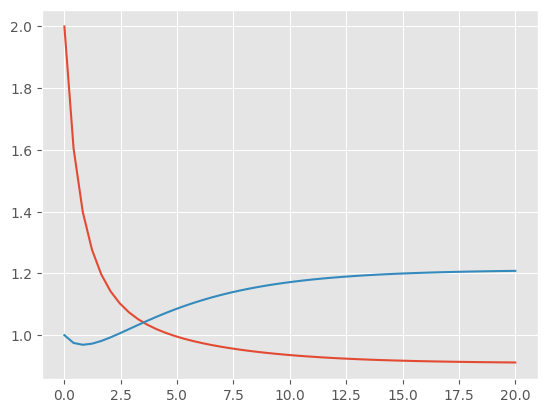

In [6]:
plt.plot(tTrain, uTrain)
plt.plot(tTrain, vTrain)

In [7]:
tTrain_sparse = np.sort(np.random.uniform(0, 20, 50))
sol_sparse = ode_solver(tTrain_sparse, initial_conditions, params) # Lösen der DGL
uTrain_sparse,vTrain_sparse = sol_sparse[:, 0], sol_sparse[:, 1]

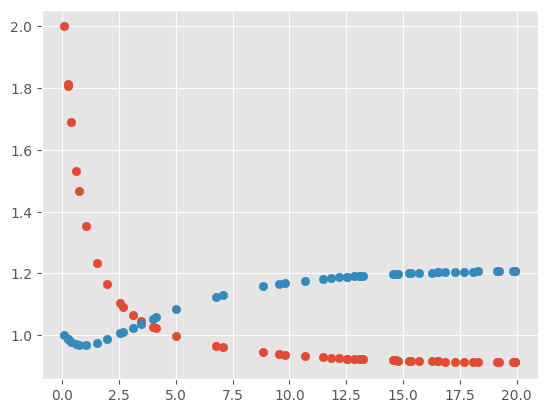

In [25]:
plt.scatter(tTrain_sparse, uTrain_sparse)
plt.scatter(tTrain_sparse, vTrain_sparse)

In [9]:
# Calculate differences between consecutive elements
differences = np.diff(tTrain_sparse)

# Check if there are unique differences
unique_differences = np.unique(differences)
unique_differences.shape

(49,)

Create SciANN model

In [10]:
# Unabhängige Variable definieren
# Model Input
t = sn.Variable("t", dtype='float64')

In [11]:
# Lösungsvariablen definieren (NN)
# NN model architecture
u = sn.Functional("u", t, 3*[5], 'tanh')
v = sn.Functional("v", t, 3*[5], 'tanh')

In [12]:

"""
u.get_weights()
[[array([[-0.19326891, -0.46008   ,  0.678417  ,  0.22510964,  1.02232791]]),   # Hidden layer 1: W
  array([-0.04804842,  0.0463088 ,  0.0089275 , -0.00219615,  0.03302138])],    # Hidden layer 1: b
 [],
 [array([[ 0.0772457 ,  0.63152843,  0.2318687 , -0.44318866, -0.35011325],     # Hidden layer 2: W
         [ 0.95458265,  0.51896372,  0.04256347,  0.14516192,  0.29379197],
         [-0.44973888, -0.05006153, -0.05867646,  0.51591113,  0.2167717 ],
         [ 0.0550965 , -0.00209104,  0.09149125,  0.99489079,  0.16031245],
         [-0.2591463 ,  0.30960036, -0.70366486, -0.29892867, -0.31824685]]),
  array([-0.01886978, -0.04967939, -0.04540217, -0.01417698, -0.01175072])],    # Hidden layer 2: b
 [],
 [array([[ 0.73360591, -0.03814174, -0.38170025,  0.07562057, -0.2454858 ],     # Hidden layer 3: w
         [ 0.1264803 , -0.4492624 ,  0.40965727,  0.08374339, -0.69458669],
         [ 0.41968586,  0.73174507,  0.14971303,  0.40562462,  0.19130253],
         [-0.55198849, -0.43681713,  0.12321841,  0.05079031,  0.58358147],
         [ 0.11372418, -0.08521081, -0.0023472 , -0.33266639,  0.54822904]]),
  array([ 0.01486306,  0.03193321,  0.00729138, -0.04757061,  0.0044467 ])],    # Hidden layer 3: b
 [],
 [array([[-0.08046311],     # Outer layer: w
         [-0.09000315],
         [ 1.23775678],
         [-0.71588579],
         [ 0.46942065]]),
  array([-0.01001793])]]    # Outer layer: b
  """
None

$$ NN1$$
survival model's fixed parameter
$$a_1 = 0.3; \quad  a_2 = 0.6; \quad b_1 = 0.7; \quad b_2 = 0.3 \quad r = 0.5$$
$$ NN2$$
co-existence model's fixed parameters
$$r = 0.5, \quad a_1=0.7, \quad a_2=0.3, \quad b_1=0.3, \quad b_2=0.6$$

In [13]:
netz = 1
# zu bestimmende Parameter
# initialize the target parameters
a1 = sn.Parameter(0.5, inputs=t, name="a1") #a1 = 0.3 or 0.7
a2 = sn.Parameter(0.5, inputs=t, name="a2") #a2 = 0.6 or 0.3
b1 = sn.Parameter(0.5, inputs=t, name="b1" ) #b1 = 0.7 or 0.3
b2 = sn.Parameter(0.5, inputs = t, name = "b2") #b2 = 0.3 or 0.6
r = sn.Parameter(0.5, inputs=t, name="r" ) #r = 0.5


In [14]:
# set up PINN-model
u_t = sn.diff(u,t)
v_t = sn.diff(v,t)

In [15]:
# Define constraints
d1 = sn.Data(u)
d2 = sn.Data(v)

#c1 = sn.Tie(u_t, u*(1-a1*u-a2*v))
#c2 = sn.Tie(v_t, r*v*(1-b1*u-b2*v))

# with the simple model output
# Model constraints
# Tie class to constrain network outputs. constraint: cond1 - cond2 == sol.
c1 = sn.Tie(u_t, u*(1-a1*u-a2*v))
c2 = sn.Tie(v_t, r*v*(1-b1*u-b2*v))

#V1) Variation der Reaktionsterme # with higher polinomial terms
#c1 = sn.Tie(u_t, u*(1-a1*u-a2*v)+e0 +e1*u+e2*v+ e3*u*u*v +e4*u*v*v)
#c2 = sn.Tie(v_t, r*v*(1-b1*u-b2*v)+f0 +f1*u+f2*v + f3*u*u*v +f4*u*v*v)

In [21]:
# set the model
model = sn.SciModel(t, [d1, d2, c1, c2]) # https://www.sciann.com/scimodels/#scimodel

In [22]:
# model input
input_data = [tTrain_sparse]

# contraints
data_d1 = uTrain_sparse
data_d2 = vTrain_sparse
data_c1 = 'zeros'
data_c2 = 'zeros'

# model output
target_data = [data_d1, data_d2, data_c1, data_c2]

In [23]:
history = model.train(
    x_true=input_data,
    y_true=target_data,
    epochs = 2000,
    batch_size=25,
    shuffle=True,
    learning_rate=0.001,
    reduce_lr_after=100,
    stop_loss_value=1e-8,
    verbose=1
)


Total samples: 50 
Batch size: 25 
Total batches: 2 

Epoch 1/2000
2/2 [==============================] - 1s 14ms/step - batch: 0.5000 - size: 25.0000 - loss: 2.6905 - u_loss: 0.8746 - v_loss: 1.7177 - sub_2_loss: 0.0862 - sub_4_loss: 0.0120 - lr: 0.0010 - time: 0.9018
Epoch 2/2000
2/2 [==============================] - 0s 3ms/step - batch: 0.5000 - size: 25.0000 - loss: 2.5301 - u_loss: 0.7870 - v_loss: 1.6362 - sub_2_loss: 0.0986 - sub_4_loss: 0.0082 - lr: 0.0010 - time: 0.0183
Epoch 3/2000
2/2 [==============================] - 0s 3ms/step - batch: 0.5000 - size: 25.0000 - loss: 2.3815 - u_loss: 0.7061 - v_loss: 1.5563 - sub_2_loss: 0.1137 - sub_4_loss: 0.0055 - lr: 0.0010 - time: 0.1055
Epoch 4/2000
2/2 [==============================] - 0s 3ms/step - batch: 0.5000 - size: 25.0000 - loss: 2.2415 - u_loss: 0.6304 - v_loss: 1.4787 - sub_2_loss: 0.1288 - sub_4_loss: 0.0037 - lr: 0.0010 - time: 0.1064
Epoch 5/2000
2/2 [==============================] - 0s 3ms/step - batch: 0.5000 - si

In [24]:
print("r: {}".format(r.value))
print("a1: {}".format(a1.value))
print("a2: {}".format(a2.value))
print("b1: {}".format(b1.value))
print("b2: {}".format(b2.value))
R.append(r.value)
A1.append(a1.value)
A2.append(a2.value)
B1.append(b1.value)
B2.append(b2.value)
# $$a_1 = 0.3; \quad  a_2 = 0.6; \quad b_1 = 0.7; \quad b_2 = 0.3 \quad r = 0.5$$
# $$r = 0.5, \quad a_1=0.7, \quad a_2=0.3, \quad b_1=0.3, \quad b_2=0.6$$

r: [0.23700813]
a1: [0.66132892]
a2: [0.33495828]
b1: [0.22902165]
b2: [0.64391608]


In [1]:
#print(R) 
# with open("b2_3x5_500_1000_end.csv","w") as file:
#         writer = csv.writer(file)
#         writer.writerows(B2)


survival model's fixed parameter
$$a_1 = 0.3; \quad  a_2 = 0.6; \quad b_1 = 0.7; \quad b_2 = 0.3 \quad r = 0.5$$
co-existence model's fixed parameters
$$r = 0.5, \quad a_1=0.7, \quad a_2=0.3, \quad b_1=0.3, \quad b_2=0.6$$

MSE u
4.320272950242521e-08
MSE v
1.713600799349764e-06
MSE uv
1.7568035288521892e-06


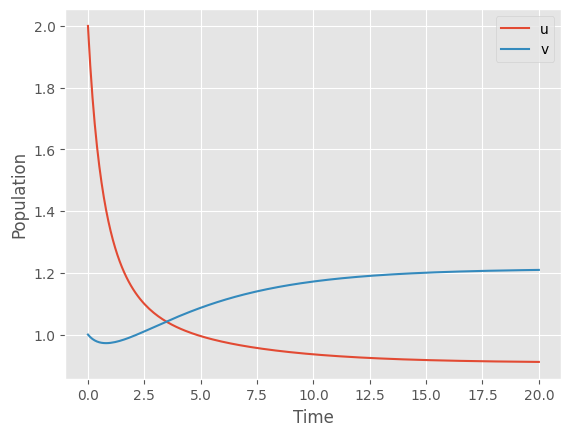

[1.7568035288521892e-06, 1.7568035288521892e-06, 1.7568035288521892e-06, 1.7568035288521892e-06]


In [22]:
# Koexistenz Intervall 10-20

#Vergleichsdaten uReal, vReal für Berechnung von mse 
params = [0.5, 0.7, 0.3, 0.3, 0.6, 0,0, 0,0 ,0,0, 0,0, 0,0] #[r, a1, a2, b1, b2]
tReal = np.linspace(0,20,200)
sol = ode_solver(tReal, initial_conditions, params) # Lösen der DGL
uReal,vReal = sol[:, 0], sol[:, 1]

# Netzausgabe berechnen u,v 
initial_conditions= [2,1] # [initu, initv]

#3x5
#params = [0.38189875, 0.67069569, 0.32491016, 0.24011706, 0.64435408, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
#params = [0.4339377, 0.69612994, 0.30319365, 0.28244125, 0.61181209, 0,0, 0,0 ,0,0, 0,0, 0,0]
#params = [0.34174093, 0.6792784, 0.31748403, 0.23128019, 0.64918542, 0,0, 0,0 ,0,0, 0,0, 0,0]
#params = [0.37056487, 0.6922162, 0.30635161, 0.24205004, 0.64238109, 0,0, 0,0 ,0,0, 0,0, 0,0]
#params = [0.41636457, 0.69115901, 0.30676238, 0.27006033, 0.62144814, 0,0, 0,0 ,0,0, 0,0, 0,0]


#5x20
#params = [0.47869945, 0.69826405, 0.30169754, 0.29705646, 0.60165003, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
#params = [0.48150626, 0.69939406, 0.30039023, 0.29660535, 0.60207248, 0,0, 0,0 ,0,0, 0,0, 0,0]
#params = [0.48671008, 0.69851907, 0.30131613, 0.29605786, 0.60288997, 0,0, 0,0 ,0,0, 0,0, 0,0]
params = [0.47606207, 0.69869112, 0.3009172, 0.29383715, 0.60403029, 0,0, 0,0 ,0,0, 0,0, 0,0]
#params = [0.4827681, 0.69888607, 0.30083315, 0.29559799, 0.60296426, 0,0, 0,0 ,0,0, 0,0, 0,0]


#1x3
#params = [0.37057557,0.51682631,0.449196, 0.27723429, 0.60393683, 0,0, 0,0, 0,0, 0,0, 0,0]
#params = [0.3428276, 0.40458873, 0.54235792, 0.08665676, 0.76473339, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
#params = [0.50606056, 0.8705696, 0.11423727, 0.654, 0.28409882, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
#params = [0.37716701, 0.37147293, 0.57989866, 0.26589103, 0.6208244, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
#params = [0.37967032, 0.60069633, 0.38346259, 0.46301139, 0.44447429, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]


# 5x10
#params = [0.46663132, 0.6965424, 0.30289002, 0.29086211, 0.60633284, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
#params = [0.462285, 0.69734527, 0.30231005, 0.28999342, 0.6068659, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
#params = [0.47007053, 0.69921809, 0.30069442, 0.29174842, 0.60572226, 0,0, 0,0 ,0,0, 0,0, 0,0] # [r, a1, a2, b1, b2]
#params = [0.46276687,0.69913026,0.30073137, 0.28816801, 0.60850452, 0,0, 0,0, 0,0, 0,0, 0,0]
#params = [0.47808672,0.69890065,0.30097513, 0.29446738, 0.60382886, 0,0, 0,0, 0,0, 0,0, 0,0]
t_pred = np.linspace(0,20,200)
sol = ode_solver(t_pred, initial_conditions, params)
u,v = sol[:, 0], sol[:, 1]

# MSE ausrechnen 
mse_u = np.sum((uReal-u)*(uReal-u))/np.size(u)
print('MSE u')
print(mse_u)

mse_v = np.sum((vReal-v)*(vReal-v))/np.size(v)
print('MSE v')
print(mse_v)

mse_uv = np.sum(( (uReal - u)*(uReal - u) + (vReal - v)*(vReal - v) ))/np.size(u)
print('MSE uv')
print(mse_uv)


# Lösung in csv-Datei speichern 
uCSV = np.array([t_pred, u])
uCSV = np.transpose(uCSV).tolist();
# with open("u_5x20_500_1000_worst.csv", "w") as file:
#         writer = csv.writer(file)
#         writer.writerows(uCSV)
        
vCSV = np.array([t_pred, v])
vCSV = np.transpose(vCSV).tolist();
# with open("v_5x20_500_1000_worst.csv", "w") as file:
#         writer = csv.writer(file)
#         writer.writerows(vCSV)

# Plot u with label
plt.plot(t_pred, u, label='u')

# Plot v with label
plt.plot(t_pred, v, label='v')

# Add legend
plt.legend()

# Add labels for x and y axes
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

MSEU.append(mse_u)
MSEV.append(mse_v)
MSEUV.append(mse_uv)
print(MSEUV)


In [ ]:
size = [4,4,4,4,4] # Kennzeichnung, welches Netz verwendet wurde (für Plot in Overleaf)
# 1 entspricht 1x3, 2 entspricht 5x10 und 3 entspricht 5x20
mseCSV = np.array([size, MSEV])
mseCSV = np.transpose(mseCSV)
mseCSV = mseCSV.tolist()
# with open("mseV_5x20_500_1000.csv","w")as file:
#         writer = csv.writer(file)
#         writer.writerows(mseCSV)